# Exploratory analyses of my dietary data

Since 28/06/2021 i've been annotating everything I ate as a way to help me make better eating habbits and as bonus I got this dataset where I will be doing an exploratory analysis in this notebook. Let's start importing the librarys and the data.

In [9]:
from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [10]:
Macros = pd.read_parquet('macros.parquet')
Medidas = pd.read_parquet('medidas.parquet')

## Treating Data

Now that we got the basics, let's make some formatting and put all important data in one DataFrame

In [11]:
#Setting the datatype as float to make us able to do operation with them
Macros = Macros.astype({c: 'float64' for c in Macros.columns})

Macros.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1060 entries, 2021-06-28 to 2024-05-20
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CARB    1060 non-null   float64
 1   PROT    1060 non-null   float64
 2   GORD    1060 non-null   float64
 3   CALS    1060 non-null   float64
dtypes: float64(4)
memory usage: 41.4 KB


<Axes: xlabel='Data'>

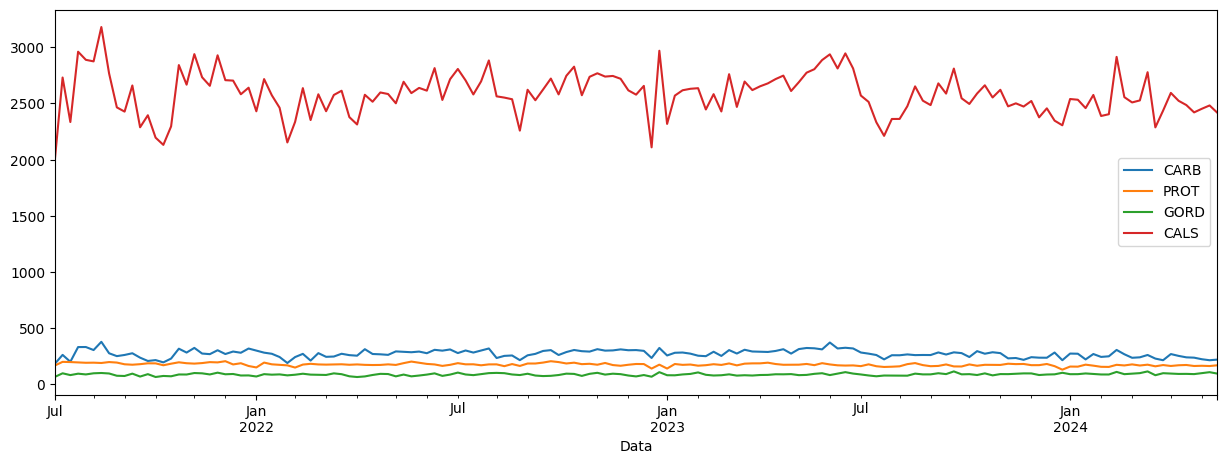

In [12]:
# Now we calculate the average macros for all saturday, wich are the days that the weights are available
# We remove the last week wich migth not have ended, so the average will be lower
Macros_week_avg = Macros.resample('W-SAT').sum().apply(lambda x: x/7)[:-1]
Macros_week_avg.plot(figsize=(15,5))

In [13]:
Medidas = Medidas.astype({c: 'float64' for c in Medidas.columns})
Medidas['Peso_diff'] = Medidas['Peso'].diff()
Medidas['Peso_diff_perc'] = Medidas['Peso_diff']/Medidas['Peso']

Medidas.info()
#Note thar neither Dataframe containd empty data, so it's not a concern when treating this data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 152 entries, 2021-06-26 to 2024-05-18
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Peso            152 non-null    float64
 1   Peso_diff       151 non-null    float64
 2   Peso_diff_perc  151 non-null    float64
dtypes: float64(3)
memory usage: 4.8 KB


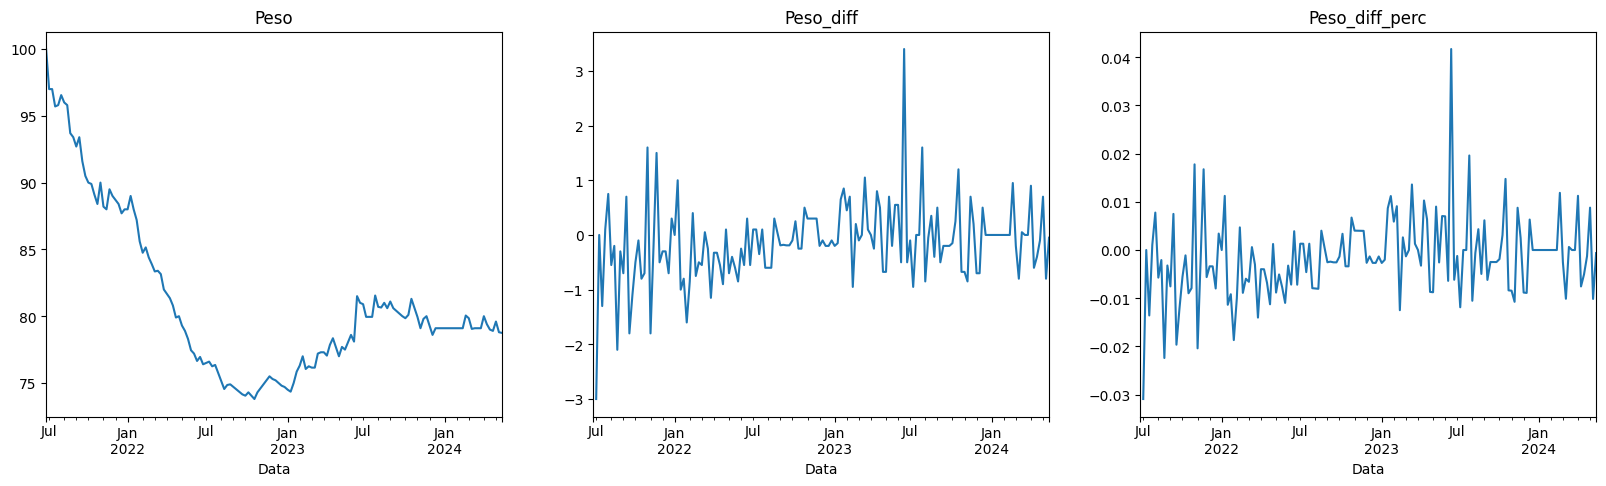

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
for i, col in enumerate(Medidas.columns):
  Medidas[col].plot(ax=ax[i])
  ax[i].set_title(col)

In [15]:
# Finally we merge both Dataframes
data = Macros_week_avg.join(Medidas, how= 'inner')
data.describe()

,CARB,PROT,GORD,CALS,Peso,Peso_diff,Peso_diff_perc
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,272.407001,175.864333,88.005298,2582.916935,80.919238,-0.140728,-0.001619
std,34.603759,12.771725,10.218204,191.364454,5.866899,0.716270,0.008459
min,183.042857,130.442857,65.000000,1997.700000,73.800000,-3.000000,-0.030928
25%,250.814286,168.828571,80.964286,2467.421429,76.800000,-0.550000,-0.006991
50%,273.171429,175.742857,88.442857,2581.857143,79.100000,-0.180000,-0.002088
75%,297.521429,183.778571,94.950000,2706.514286,82.575000,0.150000,0.001905
max,378.357143,205.914286,114.928571,3180.685714,97.000000,3.400000,0.041718


In [16]:
# Now to help the visualization further ahead i'm to make some transformations to the dataframe.

# To make the transformations possible without losing the data on the index, we're resetting it
data.reset_index(inplace=True)

#Now Setting the old index as the last column
data = data[[*data.columns[1:], data.columns[0]]]

#Then finally we melt the arrays to unite the carb, prot and gord cols one
data = data.melt(id_vars=data.columns[-5:], value_vars=data.columns[:-5], var_name='MACROS', value_name='MACROS_VALUE')
data

,CALS,Peso,Peso_diff,Peso_diff_perc,Data,MACROS,MACROS_VALUE
0,1997.700000,97.00,-3.00,-0.030928,2021-07-03,CARB,183.042857
1,2731.157143,97.00,0.00,0.000000,2021-07-10,CARB,262.028571
2,2335.128571,95.70,-1.30,-0.013584,2021-07-17,CARB,200.800000
3,2960.857143,95.80,0.10,0.001044,2021-07-24,CARB,331.614286
4,2888.685714,96.55,0.75,0.007768,2021-07-31,CARB,332.071429
...,...,...,...,...,...,...,...
448,2485.942857,79.00,-0.40,-0.005063,2024-04-20,GORD,92.985714
449,2420.714286,78.90,-0.10,-0.001267,2024-04-27,GORD,90.971429
450,2452.942857,79.60,0.70,0.008794,2024-05-04,GORD,99.900000
451,2482.500000,78.80,-0.80,-0.010152,2024-05-11,GORD,108.171429


## Calculating some parameters

To help the future investigation we are now creating some categorial data from the quantitative data. But first we are calculating the porcentages that each macros contribute to to total calories

In [17]:
#each macro contribute to a differrent total of calories, so we need to add a weight vector to compute the porcentages
def marcros_percent_calculation(row):
    if row["MACROS"] == "CARB" or row["MACROS"] == "PROT":
        return row["MACROS_VALUE"] * 4 / row["CALS"]
    elif row["MACROS"] == "GORD":
        return row["MACROS_VALUE"] * 9 / row["CALS"]

data['MACROS_PERCENT'] = data.apply(marcros_percent_calculation, axis=1)

In [18]:
data.describe()

,CALS,Peso,Peso_diff,Peso_diff_perc,Data,MACROS_VALUE,MACROS_PERCENT
count,453.000000,453.000000,453.000000,453.000000,453,453.000000,453.000000
mean,2582.916935,80.919238,-0.140728,-0.001619,2022-12-10 00:00:00,178.758877,0.333633
min,1997.700000,73.800000,-3.000000,-0.030928,2021-07-03 00:00:00,65.000000,0.226282
25%,2465.328571,76.650000,-0.550000,-0.007175,2022-03-19 00:00:00,94.971429,0.276425
50%,2581.857143,79.100000,-0.180000,-0.002088,2022-12-10 00:00:00,175.742857,0.312474
75%,2707.585714,83.150000,0.200000,0.002500,2023-09-02 00:00:00,250.585714,0.400630
max,3180.685714,97.000000,3.400000,0.041718,2024-05-18 00:00:00,378.357143,0.506765
std,190.940612,5.853904,0.714684,0.008441,NaN,78.550772,0.069353


In [19]:
# Now categorizing the quantity of macros based on how much of they deaveate from the mean
def judge_func(df):

  #Setting a series to contain the categorization results
  cat = pd.Series(dtype='category')

  for m in df.MACROS.unique():

    # we calculate a upper and lower bound based on the standart deviation of the mean
    MACRO, MACRO_index = df[df.MACROS == m].MACROS_VALUE, df[df.MACROS == m].index
    lower_lim, upper_lim = MACRO.mean() - MACRO.std(), MACRO.mean() + MACRO.std()

    #categorizing the values
    _ = pd.cut(MACRO, bins=[-np.inf, lower_lim, upper_lim, np.inf], labels=['Low', 'Medium', 'High'])

    #appending to the result series
    cat = pd.concat([cat, _], ignore_index=False)

  #Setting a name to the series column and appending it to the dataframe
  cat.name = 'MACROS_CAT'
  df = df.join(cat, how='inner')

  return df

data = judge_func(data)
data.MACROS_CAT.value_counts()

MACROS_CAT
Medium    314
Low        72
High       67
Name: count, dtype: int64

# Data visualization

it's important before we see the results to try to make some predictions as it will help to look at it more objectively. So here are my predictions:


 - As I got thinner the lower are the differences in wheight loss
 - As I know myself I tink that in days with high callories consuption will have ate too many carbs
 - There is a myth that lower cals or lower fat diets are better, but as far as I know that the important thing is total calories consumption. So I will guess that the porcentage of centain macros won't have a correlation with the wheight loss.

 ## Now we explore:

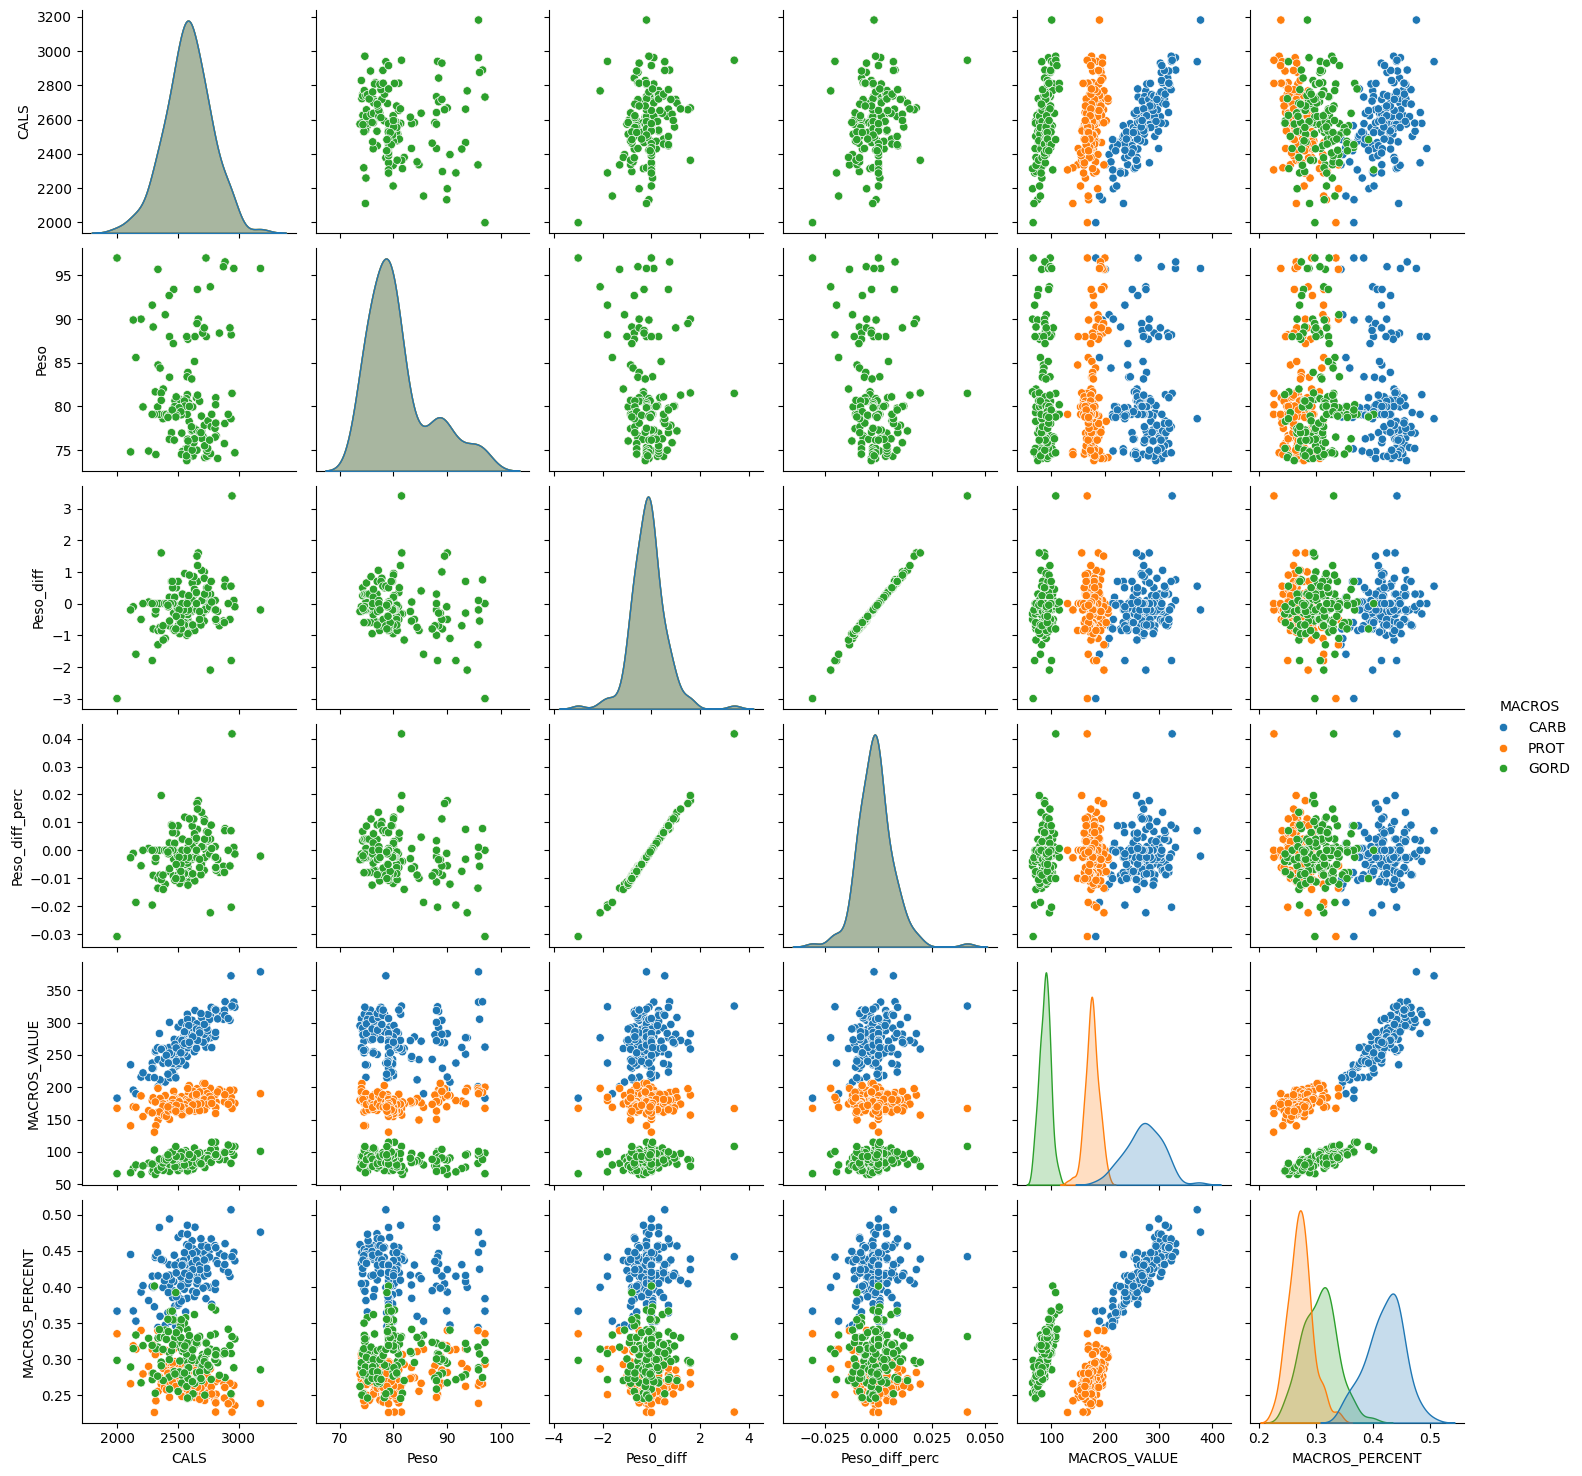

In [20]:
sns.pairplot(data, hue='MACROS')

# Observations

As allways when we do a EDA there are a few surprising finds, some predictions are proven wrong and some interesting thing arise.

## Prediction 1
My first predction is simply wrong. Thera are some outliears but the geneal treand does't really show what i thought was true. When plotted we even see the a negative corelation, but as we look at the coefficient of determination we see that it's  clear that it's hard to predict the wheight difference given the wheight.

As a bonus i saw that for the range of wheigth that i've been the percentual wheight loss and the objective wheight loss are mostly the same. Indeed the values are ofter low so de difference isn't too great. As the m value is 1/wheight we can calculate the mean wheight value found in plot, which is $≈$ 85kg. As it's redundante are deleting the peso_diff_perc

m = -0.03, b = 2.05 with r = -0.22 for Peso and Peso_diff
m = -0.00, b = 0.02 with r = -0.20 for Peso and Peso_diff_perc
m = 0.01, b = 0.00 with r = 1.00 for Peso_diff and Peso_diff_perc
The average wheight found by the regression on the last gaph is: 84.93961713717898


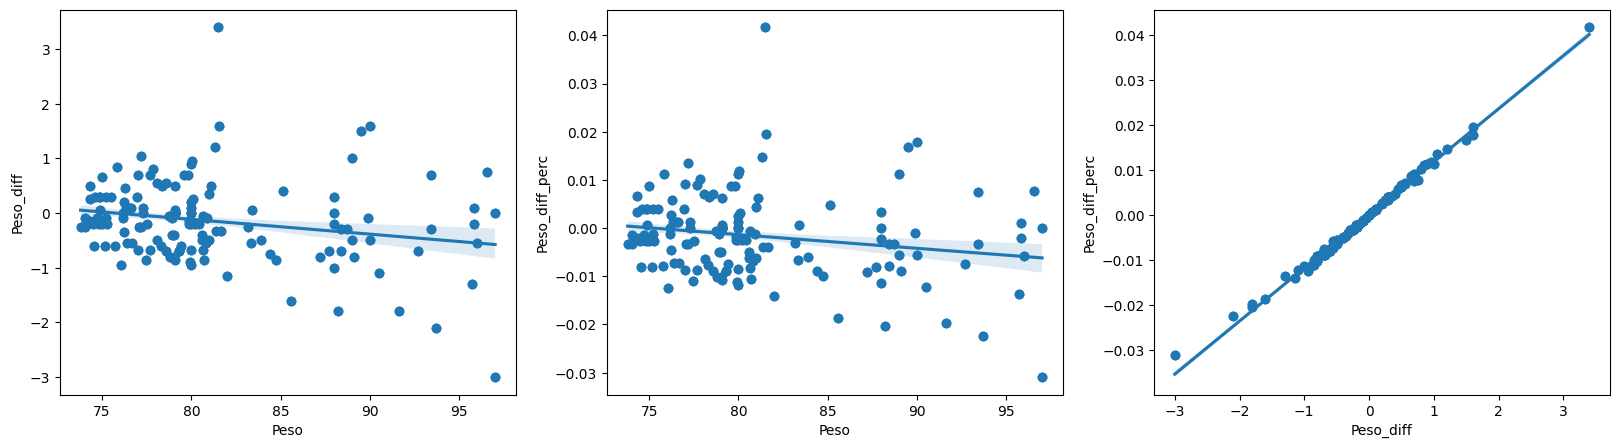

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))

for i, l in enumerate([[ 'Peso', 'Peso_diff'], ['Peso', 'Peso_diff_perc'], ['Peso_diff', 'Peso_diff_perc']]):

  sns.regplot(  data, x=l[0], y=l[1], ax = ax[i])
  slope, intercept, r_value, p_value, std_err = linregress(data[l[0]], data[l[1]])

  print(f'm = {slope:.2f}, b = {intercept:.2f} with r = {r_value:.2f} for {l[0]} and {l[1]}')
print(f'The average wheight found by the regression on the last gaph is: {1/slope}')

In [22]:
# As this is a redundat column is better to get rid of it
data.drop(columns=['Peso_diff_perc'], inplace=True)

# Prediction 2

Here I guess my prediction os on spot, the most impresive thing is the clear treandline that appeard on the absolute macros values.

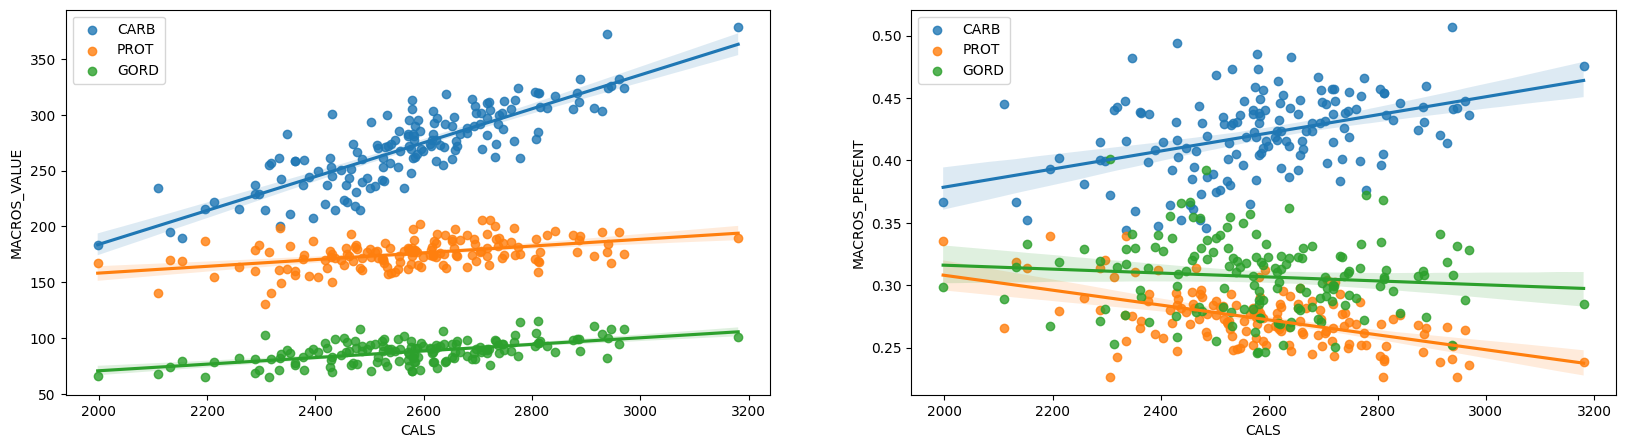

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

for i, l in enumerate(['MACROS_VALUE', 'MACROS_PERCENT']):
  for m in data.MACROS.unique():

    sns.regplot(data[data.MACROS == m], x='CALS', y=l, ax = ax[i], label=m)
    ax[i].legend()

# Prediction 3

Of course with a pool of N=1 we can't state that indeed low fat or low carb diets doesn't work, it my be individuality of mine. But this analysis shows that this kind of restrivtive diet isn't necessery for everyone to loose wheight.

The scientific consensus is that those diets generally work by limiting the calories consuption of one individual thus making him lose some wheigth. As I diet based on total calories the proportions of each macro does't really matter as shown bellow, the r values aren't big enogh to state a corelation:

m = 0.01, b = 0.42 with r = 0.18 for Pseo_diff and MACROS_PERCENT for CARB
m = -0.01, b = 0.27 with r = -0.35 for Pseo_diff and MACROS_PERCENT for PROT
m = 0.00, b = 0.31 with r = 0.07 for Pseo_diff and MACROS_PERCENT for GORD


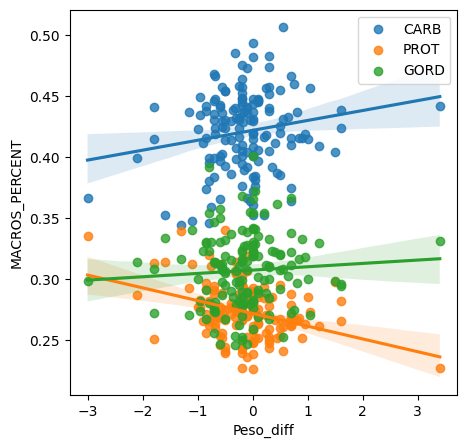

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))


for m in data.MACROS.unique():
  sns.regplot(data[data.MACROS == m], x='Peso_diff', y='MACROS_PERCENT', ax = ax, label=m)

  slope, intercept, r_value, p_value, std_err = linregress(data[data.MACROS == m]['Peso_diff'], data[data.MACROS == m]['MACROS_PERCENT'])
  print(f'm = {slope:.2f}, b = {intercept:.2f} with r = {r_value:.2f} for Pseo_diff and MACROS_PERCENT for {m}')

plt.legend()

# Avaliating a downward treand

Now let's avaliate some data over time: as we see below there is a time where my wheight falled constantly, but what are the differences in diets between this time and the rest?

In [25]:
px.line(data.groupby('Data').sample(), x='Data', y='Peso') #Jan 8 -> Jun 11
#This goupby is just to eliminate the 3 times occurance of those dots becouse of the melt we did earlier

In [26]:
# Here i'm splitting the dataFrame into two one with the period of constant weight fall, and one with the rest
data_period_of_interest = data.loc[(data['Data'] >= '2022-01-08') & (data['Data'] <= '2022-6-11' )]
data_other_period = data.loc[(data['Data'] <= '2022-01-08') | (data['Data'] >= '2022-6-11' )]

px.line(data_period_of_interest.groupby('Data').sample(), x='Data', y='Peso')

In [27]:
# Here we calculate the occurrence of each macros category
for m in data_period_of_interest.MACROS.unique():
  print(m, data_period_of_interest[data_period_of_interest.MACROS == m].MACROS_CAT.value_counts())

CARB MACROS_CAT
Medium    19
Low        2
High       2
Name: count, dtype: int64
PROT MACROS_CAT
Medium    19
High       3
Low        1
Name: count, dtype: int64
GORD MACROS_CAT
Medium    18
Low        5
High       0
Name: count, dtype: int64


Text(0, 0.5, 'Number of days')

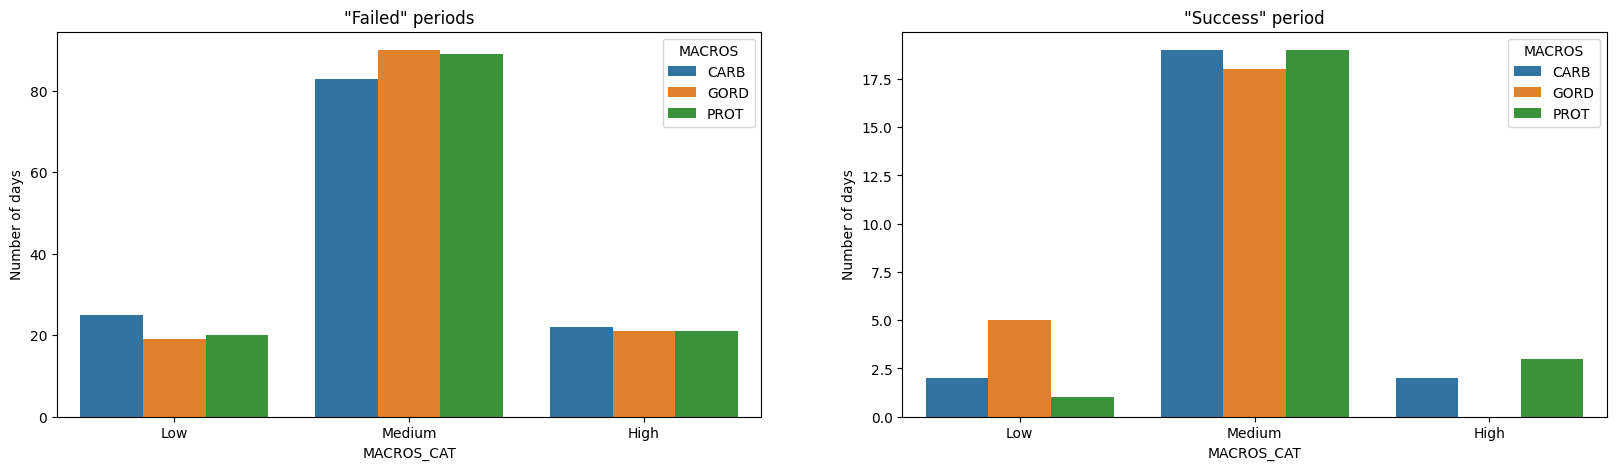

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

# Here a make groupbys to calculate how many each macros category appears
_ = data_other_period.groupby(['MACROS', 'MACROS_CAT']).count()
_.reset_index(inplace=True)

sns.barplot(data=_, x='MACROS_CAT', y='CALS', hue='MACROS', ax=ax[0])
ax[0].set_title('"Failed" periods')
ax[0].set_ylabel('Number of days')


_ = data_period_of_interest.groupby(['MACROS', 'MACROS_CAT']).count()
_.reset_index(inplace=True)

sns.barplot(data=_, x='MACROS_CAT', y='CALS', hue='MACROS', ax=ax[1])
ax[1].set_title('"Success" period')
ax[1].set_ylabel('Number of days')

(1707.0026717817364, 3506.211147287264)

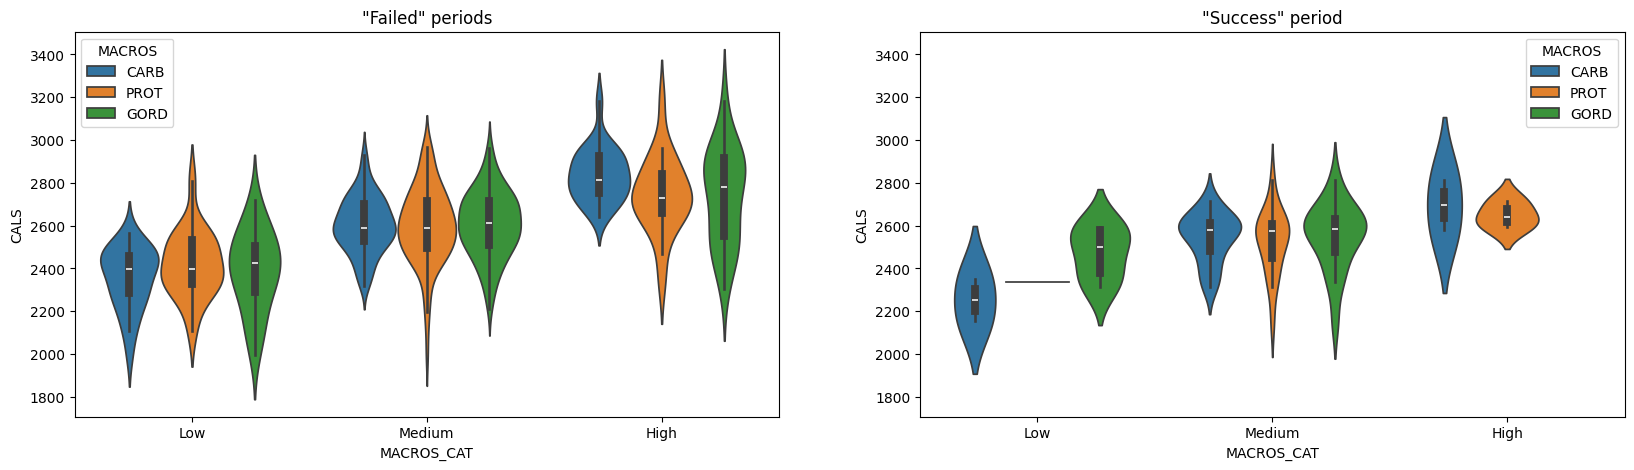

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.violinplot(data_other_period, hue='MACROS', y='CALS', x='MACROS_CAT', ax=ax[0])
ax[0].set_title('"Failed" periods')
sns.violinplot(data_period_of_interest, hue='MACROS', y='CALS', x='MACROS_CAT', ax=ax[1])
ax[1].set_title('"Success" period')

y_min, y_max = ax[0].get_ylim()
ax[1].set_ylim([y_min, y_max])

In [30]:
def calc_mean_std(df, period, _):
  for m in df.MACROS.unique():
    for cat in df.MACROS_CAT.unique():
      mean = np.mean(df[(df.MACROS == m) & (df.MACROS_CAT == cat)]['CALS'])
      std = np.std(df[(df.MACROS == m) & (df.MACROS_CAT == cat)]['CALS'])
      try:
        _.loc[len(_)] = [cat, m, period, round(mean), round(std)]
      except:
        print(f'{cat.lower()} {m.lower()} of the {period} period do not have data' )
  return _

deviations = pd.DataFrame(columns=['MACROS_CAT', 'MACROS', 'PERIOD', 'MEAN', 'STD'])
deviations = calc_mean_std(data_period_of_interest, 'Success', deviations)
deviations = calc_mean_std(data_other_period, 'Failed', deviations)
deviations

high gord of the Success period do not have data


,MACROS_CAT,MACROS,PERIOD,MEAN,STD
0,Medium,CARB,Success,2545,111
1,Low,CARB,Success,2253,100
2,High,CARB,Success,2696,119
3,Medium,PROT,Success,2525,147
4,Low,PROT,Success,2336,0
5,High,PROT,Success,2649,51
6,Medium,GORD,Success,2550,152
7,Low,GORD,Success,2473,110
8,Low,CARB,Failed,2353,140
9,Medium,CARB,Failed,2603,131


Text(0.5, 1.0, 'Mean x deviation')

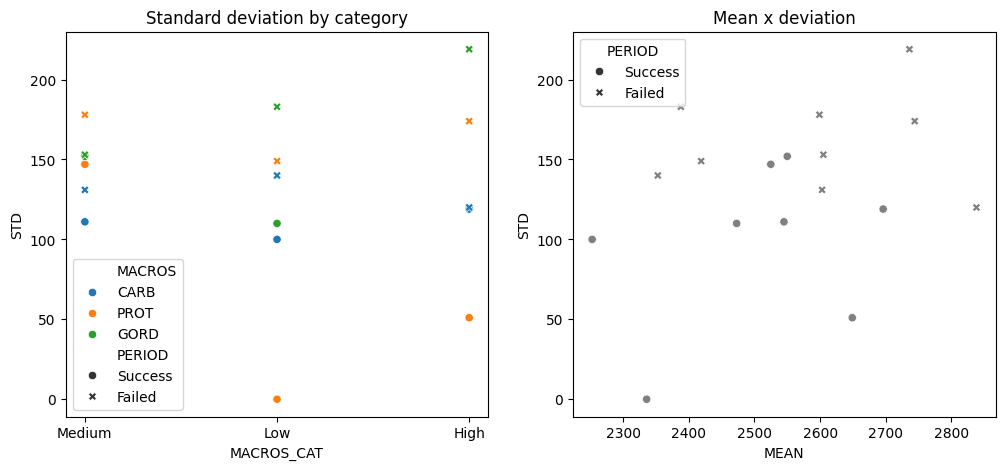

In [31]:
fig, ax = plt.subplots( 1, 2, figsize=(12, 5) )
sns.scatterplot( data=deviations, x='MACROS_CAT', y='STD', hue='MACROS', style='PERIOD', ax = ax[0] )
sns.scatterplot( data=deviations, x='MEAN', y='STD', style='PERIOD', c='gray', ax = ax[1] )
ax[0].set_title('Standard deviation by category')
ax[1].set_title('Mean x deviation')

# Conclusion

I gess it might not be a surprise, but te data show that the key is consistency. We can see it clearly on the last plot, the deviations of how I ate in this period are almost always lower when compared to periods where I didn't loose wheigth as expected. And even in the bar plots we can see that the times that I ate too little or too much were fewer in proportion when copared to the "fail" period.

At last I must acknowledge that wheight loss is a multifactiorial process, and i didn't track all that factors that would helped a analysis like this like: water consuption, sleep time, and most importantly some mesure of how much activity I had done. But besides this, I think we got some pretty intersting insights.